# RAG-based Document Information Retrieval

## 0. Environment Setup

In [ ]:
! pip install -q torch transformers accelerate bitsandbytes langchain deepeval sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. Document Setup

Let's choose a textbook as our knowledge base. Specifically, Jurafsky's Speech and Language Processing textbook, a great resource for classical and neural NLP with a nice broad coverage of topics with detailed, deep explanations. For a resource like a textbook, recursive text splitting will suffice since subtopics are nearly always split by chapter and paragraph separations.

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders import PyPDFDirectoryLoader

file_path = '/content/gdrive/My Drive/SLP_2025.pdf'
loader = PyPDFLoader(file_path)


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=950,
    chunk_overlap=int(950/10),
    add_start_index=True,
    strip_whitespace=True,
    separators=MARKDOWN_SEPARATORS
)

docs = loader.load()
split_docs = text_splitter.split_documents(docs)

print(split_docs[100])

We want to visualize the distribution of the token lengths of our chunks post-text-splitting. We also need to check that the max token length doesn't exist the max sequence length limit of the embedding model that we're using so that we don't lose information. After experimenting a bit, the largest chunk size that gets all the embeddings under 512 is 950 tokens.

## 2. Embedding Generation

GTE is a text-to-embedding model that we're going to use to generate embeddings from our document chunks, which has a max sequence length of 512.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/2385 [00:00<?, ?it/s]

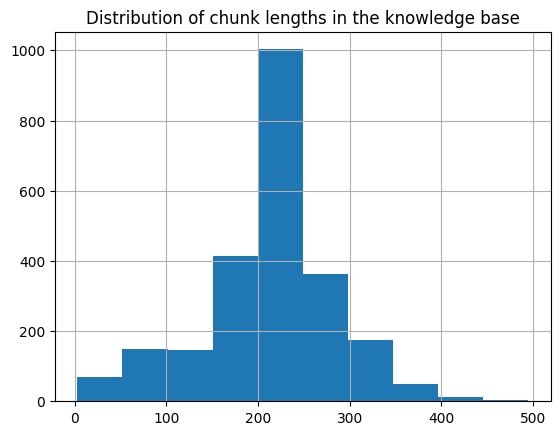

Max document embedding length: 495


In [ ]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(split_docs)]

fig = pd.Series(lengths).hist()
plt.title("Distribution of chunk lengths in the knowledge base")
plt.show()

print(f'Max document embedding length: {max(lengths)}')

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True}
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    split_docs, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-7-2b695a0efd89>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [ ]:
user_query = "What problems does retrieval-augmented generation address?"

In [ ]:
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)

print(retrieved_docs[0].page_content)

print(retrieved_docs[0].metadata)

## 3. Reader Model

We want to choose a small language model (because I don't have unlimited compute (yet)) and let's use the Open LLM Leaderboard to find a model. The model with the highest leaderboard ranking that's under 7.5 params is Falcon3-7B-Instruct.

Another reason to choose a small model, other than Katya's resources limit, is that it's worthwhile to explore how big of a model we actually need in order to get good task performance. The magic of RAG is that we're plugging in our reader model into a knowledge database - the model doesn't need to have seen/learned the knowledge well to do information retrieval anymore. However, it's also worth considering that it's good if we have a model with some exposure to the domain we are looking at via pre-training and/or fine-tuning.

In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "tiiuae/Falcon3-7B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=1000,
)

In [ ]:
READER_LLM('What problems does retrieval-augmented generation address?')

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context, give a comprehensive answer to the question.
                      Respond only to the question asked, response should be concise and relevant to the question.
                      Provide the number of the source document when relevant.
                      If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
        {context}
        ---
        Now here is the question you need to answer.

        Question: {question}""",
    },
]

RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(prompt_in_chat_format, tokenize=False, add_generation_prompt=True)
print(RAG_PROMPT_TEMPLATE)

In [ ]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
context = "\nExtracted documents:\n"
context += "".join( [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)] )

final_prompt = RAG_PROMPT_TEMPLATE.format(question="What problems does retrieval-augmented generation address?", context=context)

answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

In [ ]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 35,
    num_docs_final: int = 7
):

    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    if reranker:
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    context = "\n Extracted documents: \n"
    context += "".join( [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [ ]:
question = "What problems does retrieval-augmented generation address?"
answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)
print('answer: ', answer)
print('relevant docs: ', relevant_docs)

### Comparing performance with and without reranking retrieved docs:

**Before reranking:** \\
"Retrieval-augmented generation addresses the problems of hallucination, inability to show textual evidence to support the answer, and inability to answer questions from proprietary data. It also ensures answers are grounded in facts from curated datasets and provides users with the context of the passage or document the answer came from, enhancing confidence in the answer's accuracy."


**After reranking:** \\
"Retrieval-augmented generation addresses several problems with simple prompting for question answering:\n\n1. It helps ensure that the answer is grounded in facts from a curated dataset.\n2. The system can provide the user with the answer accompanied by the context of the passage or document the answer came from.\n3. It solves issues related to hallucination, inability to show textual evidence, and inability to answer questions from proprietary data.\n\nThese improvements make retrieval-augmented generation a more reliable method for question answering compared to simple prompting."

## 4. Building Synthetic QA Dataset

So we've created a RAG pipeline - yay! But we need some sort of way to evaluate its performance. In order to do that, we create a synthetic dataset in the follow way: We take a random sample of the generated chunks, and for each chunk, we ask an instruction following LLM to generate a question-answer pair; the chunk is to be used as context and should contain the question's answer.

Instruction Following Model of Choice: allenai/Llama-3.1-Tulu-3.1-8B

In [ ]:
AGENT_MODEL_NAME = "allenai/Llama-3.1-Tulu-3.1-8B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained( AGENT_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(AGENT_MODEL_NAME)

AGENT_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=1000,
)

In [ ]:
QA_generation_prompt = """
Your task is to write a study question and an answer for it given the context which is a passage from a textbook.
Your study question should test a student's understanding, recall, and critical thinking of the provided context.
Your study question should be formulated in the same style as a question that could come up on a college exam.
This means that your study question MUST NOT mention something like "according to the passage" or "context".
The study question should be answerable looking only at the provided context and should not reference other passages in the textbook.
The study question should only focus on topics related to linguistics, computer science, natural language processing, and machine learning.

Provide your answer as follows:

Output:::
Study question: (your study question)
Answer: (your answer to the study question)

Now here is the context.

Context: {context}\n
Output:::"""

In [ ]:
import random

N_GENERATIONS = 0  # We intentionally generate only 10 QA couples here for cost and time considerations

print(f"Generating {N_GENERATIONS} QA couples...")

synthetic_dataset = []
for sampled_context in tqdm(random.sample(split_docs, N_GENERATIONS)):
  try:
    sequences = AGENT_LLM(
        QA_generation_prompt.format(context=sampled_context.page_content),
        max_new_tokens=1000,
        do_sample=True,
        top_k=10,
        return_full_text = False,
        )

    question, answer = sequences[0]['generated_text'].split('\nAnswer:')
    question = question.split('Study question: ')[1]
    qa_dict = {'question':question, 'answer':answer, 'context':sampled_context.page_content}
    print(qa_dict)
    synthetic_dataset.append(qa_dict)
  except:
        continue

In [ ]:
import pickle

dataset1_fp = '/content/gdrive/My Drive/synthetic_dataset_1.pickle'
dataset2_fp = '/content/gdrive/My Drive/synthetic_dataset_2.pickle'
dataset3_fp = '/content/gdrive/My Drive/synthetic_dataset_3.pickle'

# with open(dataset3_fp, 'wb') as file:
#     pickle.dump(synthetic_dataset, file)

In [ ]:
with open(dataset1_fp, 'rb') as file:
    dataset1 = pickle.load(file)
len(dataset1)

82

In [ ]:
with open(dataset2_fp, 'rb') as file:
    dataset2 = pickle.load(file)
len(dataset2)

25

In [ ]:
with open(dataset3_fp, 'rb') as file:
    dataset3 = pickle.load(file)
len(dataset3)

40

In [ ]:
synthetic_dataset = dataset1 + dataset2 + dataset3
synthetic_dataset[:2]

[{'question': 'What are some key issues discussed by Ng regarding coreference resolution?',
  'answer': 'Key issues discussed by Ng regarding coreference resolution include issues in representation and optimization, local classification versus global ranking approaches, and improvements in supervised ranking methods. Additionally, Ng provides a retrospective overview of the first fifteen years of research in this field, highlighting significant developments and challenges encountered during this period.',
  'context': 'Neff, G. and P. Nagy. 2016. Talking\nto bots: Symbiotic agency and the\ncase of Tay. International Journal\nof Communication, 10:4915–4931.\nNg, A. Y . and M. I. Jordan. 2002. On\ndiscriminative vs. generative classi-\nﬁers: A comparison of logistic re-\ngression and naive bayes. NeurIPS.\nNg, H. T., L. H. Teo, and J. L. P. Kwan.\n2000. A machine learning approach\nto answering questions for reading\ncomprehension tests. EMNLP.\nNg, V . 2004. Learning noun phrase\nanapho

 ## 5. RAG Eval

Now that we have a golden standard dataset, we can evaluate the RAG pipeline. Given a question from our dataset, we know what chunk is the most relevant to the question (the chunk from which the question was generated) and we want to observe that the chunk is retreived. Then, we want to make sure that the answer the RAG pipeline generates matches the true answer and that it was found in the retrieved chunk.

We will perform this evaluation with an agentic workflow: we will use a library, DeepEval, that prompts gpt-4o to evaluate multiple RAG metrics:
- Answer Relevancy
- Faithfulness
- Contextual Recall
- Contextual Precision
- Contextual Relevancy

More specifically, the LLM will give a score from 0-5 for each metric, and then sees how many question-answer-context instances pass a specific threshold (say, 3), and returns the percentage of instances that have passed the threshold.

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = ''

In [ ]:
from deepeval.test_case import LLMTestCase
from deepeval.dataset import EvaluationDataset

In [ ]:
from random import sample


test_cases = []
for datum in sample(synthetic_dataset,0):
  question, expected_answer, context = datum['question'], datum['answer'], datum['context']
  actual_answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

  test_case = LLMTestCase(
    input=question,
    expected_output=expected_answer,
    actual_output=actual_answer,
    retrieval_context=[context]
  )

  test_cases.append(test_case)



Results:


In [ ]:
# with open('/content/gdrive/My Drive/rag_test_cases.pickle', 'wb') as file:
#     pickle.dump(test_cases, file)

In [ ]:
import pickle
with open('/content/gdrive/My Drive/rag_test_cases.pickle', 'rb') as file:
    test_cases = pickle.load(file)


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from deepeval.models.base_model import DeepEvalBaseLLM
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

class Llama3_8B(DeepEvalBaseLLM):
    def __init__(self):
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
        )

        model_4bit = AutoModelForCausalLM.from_pretrained(
            "togethercomputer/LLaMA-2-7B-32K",
            device_map="auto",
            quantization_config=quantization_config,
        )
        tokenizer = AutoTokenizer.from_pretrained(
            "togethercomputer/LLaMA-2-7B-32K",
        )

        self.model = model_4bit
        self.tokenizer = tokenizer

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        pipeline = transformers.pipeline(
            "text-generation",
            model=model,
            tokenizer=self.tokenizer,
            use_cache=True,
            device_map="auto",
            max_length=2500,
            do_sample=True,
            top_k=5,
            num_return_sequences=1,
            eos_token_id=self.tokenizer.eos_token_id,
            pad_token_id=self.tokenizer.eos_token_id,
        )

        return pipeline(prompt)

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "Llama-3 8B"

# llama_8B = Llama3_8B()

In [ ]:
from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric, ContextualRecallMetric, ContextualPrecisionMetric, ContextualRelevancyMetric

answer_relevancy_metric = AnswerRelevancyMetric(model='gpt-4o-mini')
faithfulness_metric = FaithfulnessMetric(model='gpt-4o-mini')
contextual_recall_metric = ContextualRecallMetric(model='gpt-4o-mini')
contextual_precision_metric = ContextualPrecisionMetric(model='gpt-4o-mini')
contextual_relevancy_metric = ContextualRelevancyMetric(model='gpt-4o-mini')

In [ ]:
from deepeval import evaluate
import transformers

eval_result = evaluate(test_cases, max_concurrent = 5, metrics = [answer_relevancy_metric, faithfulness_metric, contextual_recall_metric,contextual_precision_metric, contextual_relevancy_metric])

Overall Metric Pass Rates

Answer Relevancy: 96.00% pass rate

Faithfulness: 99.00% pass rate

Contextual Recall: 97.00% pass rate

Contextual Precision: 95.00% pass rate

Contextual Relevancy: 60.00% pass rate

In [ ]:
with open('/content/gdrive/My Drive/rag_eval.pickle', 'wb') as file:
     pickle.dump(eval_result, file)

## 6. Sources

- [https://huggingface.co/spaces/lmarena-ai/chatbot-arena-leaderboard](https://huggingface.co/spaces/lmarena-ai/chatbot-arena-leaderboard)
- [https://huggingface.co/learn/cookbook/en/rag_evaluation](https://huggingface.co/learn/cookbook/en/rag_evaluation)
- [https://huggingface.co/tiiuae/Falcon3-7B-Instruct?library=transformers](https://huggingface.co/tiiuae/Falcon3-7B-Instruct?library=transformers)
- [https://huggingface.co/docs/transformers/en/tasks/prompting](https://huggingface.co/docs/transformers/en/tasks/prompting)
- [https://github.com/confident-ai/deepeval](https://github.com/confident-ai/deepeval)
- [https://huggingface.co/learn/cookbook/en/advanced_rag](https://huggingface.co/learn/cookbook/en/advanced_rag)